# Get the Data

In [1]:
import os

DATASETS_DIR = 'datasets'
MODELS_DIR = 'models'
TAR_DIR = os.path.join(DATASETS_DIR, 'tar')

SPAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2'
EASY_HAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2'

In [2]:
from urllib.request import urlretrieve
import tarfile
import shutil

def download_dataset(url):
    """download and unzip data from a url into the specified path"""
    
    # create directory if it doesn't exist
    if not os.path.isdir(TAR_DIR):
        os.makedirs(TAR_DIR)
    
    filename = url.rsplit('/', 1)[-1]
    tarpath = os.path.join(TAR_DIR, filename)
    
    # download the tar file if it doesn't exist
    try:
        tarfile.open(tarpath)
    except:
        urlretrieve(url, tarpath)
    
    with tarfile.open(tarpath) as tar:
        dirname = os.path.join(DATASETS_DIR, tar.getnames()[0])
        if os.path.isdir(dirname):
            shutil.rmtree(dirname)
        tar.extractall(path=DATASETS_DIR)
        
        cmds_path = os.path.join(dirname, 'cmds')
        if os.path.isfile(cmds_path):
            os.remove(cmds_path)
    
    return dirname

In [3]:
# download the data
spam_dir = download_dataset(SPAM_URL)
easy_ham_dir = download_dataset(EASY_HAM_URL)

In [4]:
import numpy as np
import glob

def load_dataset(dirpath):
    """load emails from the specified directory"""
    
    files = []
    filepaths = glob.glob(dirpath + '/*')
    for path in filepaths:
        with open(path, 'rb') as f:
            byte_content = f.read()
            str_content = byte_content.decode('utf-8', errors='ignore')
            files.append(str_content)
    return files
    

In [5]:
# load the datasets
spam = load_dataset(spam_dir)
easy_ham = load_dataset(easy_ham_dir)

In [6]:
import sklearn.utils

# create the full dataset
X = spam + easy_ham 
y = np.concatenate((np.ones(len(spam)), np.zeros(len(easy_ham))))

# shuffle the dataset
X, y = sklearn.utils.shuffle(X, y, random_state=2)

In [7]:
from sklearn.model_selection import train_test_split

# split the data into stratified training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

In [8]:
# check dataset shapes
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

2236 2236
560 560


# Data Preparation Pipeline

In [9]:
def remove_header(email):
    """remove the header from an email"""
    return email[email.index('\n\n'):]

In [10]:
import re 

def is_url(s):
    url = re.match("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|"
                     "[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", s)
    return url is not None

def convert_url_to_word(words):
    """convert all urls in the list to the word 'URL'"""
    for i, word in enumerate(words):
        if is_url(word):
            words[i] = 'URL'
    return words

In [11]:
def convert_num_to_word(words):
    """convert all numbers in the list to the word 'NUM'"""
    for i, word in enumerate(words):
        if word.isdigit():
            words[i] = 'NUM'
    return words

In [12]:
def remove_punctuation(email):
    new_email = ""
    for c in email:
        if c.isalnum() or c.isspace():
            new_email += c
    return new_email

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class CleanEmails(BaseEstimator, TransformerMixin):
    def __init__(self, no_header=True, to_lowercase=True, url_to_word=True, num_to_word=True,
                 remove_punc=True):
        self.no_header = no_header
        self.to_lowercase = to_lowercase
        self.url_to_word = url_to_word
        self.num_to_word = num_to_word
        self.remove_punc = remove_punc
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_cleaned = []
        for email in X:
            if self.no_header:
                email = remove_header(email)
            if self.to_lowercase:
                email = email.lower()
            
            email_words = email.split()
            if self.url_to_word:
                email_words = convert_url_to_word(email_words)
            if self.num_to_word:
                email_words = convert_num_to_word(email_words)
            email = ' '.join(email_words)
            if self.remove_punc:
                email = remove_punctuation(email)
            X_cleaned.append(email)
        return X_cleaned
        

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# full preparation pipeline
prepare_pipeline = Pipeline([
    ('clean_email', CleanEmails()),
    ('bag_of_words', CountVectorizer())
])

In [15]:
# prepare the training data
X_train_prepared = prepare_pipeline.fit_transform(X_train)

In [16]:
print(X_train_prepared.shape)

(2236, 69207)


# Train and Evaluate some Classifiers

## Classifiers to try
- MLPClassifier
- DecisionTreeClassifier
- RandomForestClassifier
- AdaBoostClassifier
- KNNClassifier
- SVC

## How to evaluate each classifier
- Using 3-fold cross validation:
 - Evaluate accuracy
 - Calculate the confusion matrix, precision, recall and f1-score
- Select some promising models
 - For models that implement decision_function() or predict_probas(),
  - Plot the precision vs recall curve
  - Plot ROC curve and calculate the ROC AUC
- Pick the classifier with best precision and recall

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def eval_confusion(y_pred, y_true=y_train):
    conf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {'matrix': conf_matrix, 'precision': precision, 'recall': recall, 'f1': f1}

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [19]:
import warnings
# stop scikit-learn's deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [20]:

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Classification Models
mlp_clf = MLPClassifier(hidden_layer_sizes=(16,))
tree_clf = DecisionTreeClassifier()
forest_clf = RandomForestClassifier()
adaboost_clf = AdaBoostClassifier()
knn_clf = KNeighborsClassifier()
svm_clf = SVC()

classifiers = {
    'Decision Tree': tree_clf,
    'Random Forest': forest_clf,
    'AdaBoost': adaboost_clf,
    'KNN': knn_clf,
    'SVM': svm_clf,
    'MLP': mlp_clf
}

In [21]:
from sklearn.model_selection import cross_val_predict

# make predictions using each model
y_preds = {}
for clf_name, clf in classifiers.items():
    y_preds[clf_name] = cross_val_predict(clf, X_train_prepared, y_train, cv=3)

In [22]:
from sklearn.metrics import accuracy_score

# evaluate each classifier's accuracy
for clf_name, y_pred in y_preds.items():
    print(f"{clf_name}:")
    print(accuracy_score(y_train, y_pred))
    print()

Decision Tree:
0.9414132379248659

Random Forest:
0.9789803220035778

AdaBoost:
0.9704830053667263

KNN:
0.924865831842576

SVM:
0.9141323792486583

MLP:
0.9852415026833632



In [23]:
# evaluate the confusion matrix, precision, recall and f1 score for each classifier
for clf_name, y_pred in y_preds.items():
    conf = eval_confusion(y_pred)
    print(f"{clf_name}:")
    print(conf['matrix'])
    print(f"precision: {conf['precision']}")
    print(f"recall: {conf['recall']}")
    print(f"f1-score: {conf['f1']}")
    print()

Decision Tree:
[[1046   74]
 [  57 1059]]
precision: 0.9346866725507502
recall: 0.9489247311827957
f1-score: 0.9417518897287683

Random Forest:
[[1103   17]
 [  30 1086]]
precision: 0.9845874886672711
recall: 0.9731182795698925
f1-score: 0.978819287967553

AdaBoost:
[[1087   33]
 [  33 1083]]
precision: 0.9704301075268817
recall: 0.9704301075268817
f1-score: 0.9704301075268817

KNN:
[[1064   56]
 [ 112 1004]]
precision: 0.9471698113207547
recall: 0.899641577060932
f1-score: 0.922794117647059

SVM:
[[1096   24]
 [ 168  948]]
precision: 0.9753086419753086
recall: 0.8494623655913979
f1-score: 0.9080459770114943

MLP:
[[1114    6]
 [  27 1089]]
precision: 0.9945205479452055
recall: 0.9758064516129032
f1-score: 0.9850746268656717



- SVM doesn't seem to be promising
- Best model so far is the MLP classifier
- Second best model is the Random Forest classifier

In [24]:
from sklearn.model_selection import cross_val_predict

# calculate scores for each model
y_scores = {}
clf_thresholds = {}

for clf_name, clf in classifiers.items():
    method = 'predict_proba'
    if not hasattr(clf, 'predict_proba') and hasattr(clf, 'decision_function'):
        method = 'decision_function'
    y_scores[clf_name] = cross_val_predict(clf, X_train_prepared, y_train, cv=3,
                                           method=method)
    if method == 'predict_proba':
        y_scores[clf_name] = y_scores[clf_name][:,1]
        clf_thresholds[clf_name] = 0.5
    else:
        clf_thresholds[clf_name] = 0

In [25]:
from sklearn.metrics import precision_recall_curve

def plot_precision_vs_recall(y_scores, threshold=0, label=None, style='b-'):
    """plot precision vs recall for different thresholds, highlight the specified threshold"""
    
    # calculate scores and precisions and recalls at different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    
    # plot the precision and recall curves
    plt.plot(recalls, precisions, style, label=label)
    
    # highlight the threshold
    y_pred = y_scores >= threshold
    hl_precision = precision_score(y_train, y_pred)
    hl_recall = recall_score(y_train, y_pred)
    
    plt.plot([0, hl_recall], [hl_precision, hl_precision], 'r:')
    plt.plot([hl_recall, hl_recall], [0, hl_precision], 'r:')
    plt.plot([hl_recall], [hl_precision], 'ro')

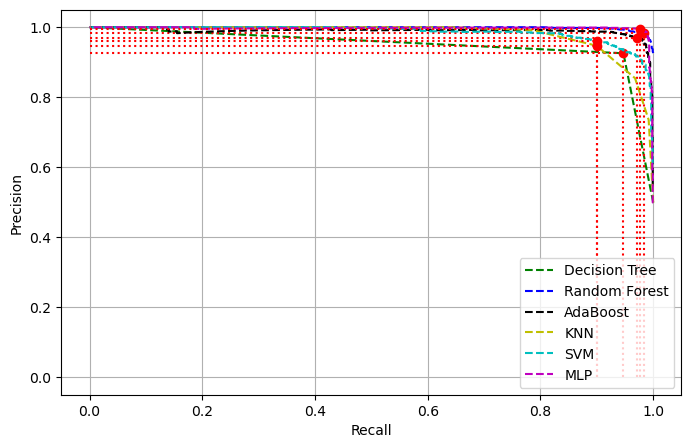

In [39]:
# plot recall vs precision for each model
mpl.style.use('default')
plt.figure(figsize=(8, 5))

styles = {
    'Decision Tree': 'g--',
    'Random Forest': 'b--',
    'AdaBoost': 'k--',
    'KNN': 'y--',
    'SVM': 'c--',
    'MLP': 'm--'
}

for clf_name, y_score in y_scores.items():
    plot_precision_vs_recall(y_score, threshold=clf_thresholds[clf_name], label=clf_name,
                             style=styles[clf_name])
    
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()

In [28]:
from sklearn.metrics import roc_curve

def plot_roc(y_scores, threshold=0, label=None, style='b-'):
    """plot the ROC curve"""
    
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    
    # plot the ROC curve
    plt.plot(fpr, tpr, style, label=label)
    
    # false positive rate: false positives / true negatives + false positives
    # true positive rate (recall): true positives / (true positives + false negatives)
    # highlight the threshold
    y_pred = y_scores > threshold
    hl_fp = np.sum(np.logical_and(y_pred == True, y_train == 0))
    hl_tp = np.sum(np.logical_and(y_pred == True, y_train == 1))
    hl_fpr = hl_fp / np.sum(y_train == 0)
    hl_tpr = hl_tp / np.sum(y_train == 1)
    
    plt.plot([0, hl_fpr], [hl_tpr, hl_tpr], 'r:')
    plt.plot([hl_fpr, hl_fpr], [0, hl_tpr], 'r:')
    plt.plot([hl_fpr], [hl_tpr], 'ro')

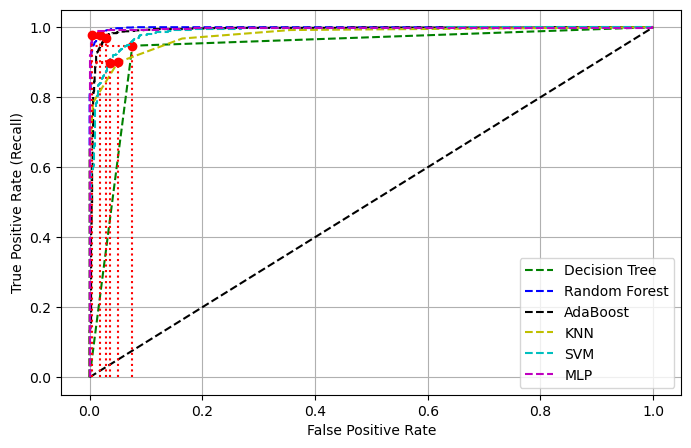

In [29]:
# plot ROC curve for each model
mpl.style.use('default')
plt.figure(figsize=(8, 5))

# ROC for purely random classifier
plt.plot([0, 1], [0, 1], 'k--')

for clf_name, y_score in y_scores.items():
    plot_roc(y_score, threshold=clf_thresholds[clf_name], label=clf_name, style=styles[clf_name])
    
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.show()

In [30]:
# calculate all ROC AUCs
from sklearn.metrics import roc_auc_score

print("ROC AUC scores:")
for clf_name, y_score in y_scores.items():
    roc_auc = roc_auc_score(y_train, y_score)
    print(f"- {clf_name}: {roc_auc}")

ROC AUC scores:
- Decision Tree: 0.9356198796722991
- Random Forest: 0.9985919098822325
- AdaBoost: 0.9921402969790067
- KNN: 0.977264144905274
- SVM: 0.98636472734255
- MLP: 0.9965149769585253


## Best classifiers to fine-tune:
- MLP
- AdaBoost
- Random Forest

# Fine-tune the Best Classifiers

## To fine-tune each model:
- Use Grid Search or Random Search depending on the model type and use 5-fold CV
- Save each model to a file
- Evaluate the model on the test set

In [31]:
from sklearn.model_selection import GridSearchCV

# fine-tune MLP classifier
mlp_best = MLPClassifier()
mlp_param_grid = {
    'hidden_layer_sizes': [(16,), (16, 16), (32,)],
    'activation': ['relu', 'tanh', 'logistic']
}

mlp_grid_search = GridSearchCV(mlp_best, mlp_param_grid, scoring='f1', cv=5, verbose=1)
mlp_grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [(16,), (16, 16), (32,)]},
             scoring='f1', verbose=1)

In [32]:
# fine-tune AdaBoost classifier
adaboost_best = AdaBoostClassifier()
adaboost_param_grid = {
    'n_estimators': [10, 30, 50, 100]
}

adaboost_grid_search = GridSearchCV(adaboost_best, adaboost_param_grid, scoring='f1', cv=5, verbose=2)
adaboost_grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ....................................n_estimators=10; total time=   1.5s
[CV] END ....................................n_estimators=10; total time=   1.3s
[CV] END ....................................n_estimators=10; total time=   1.3s
[CV] END ....................................n_estimators=10; total time=   1.3s
[CV] END ....................................n_estimators=10; total time=   1.3s
[CV] END ....................................n_estimators=30; total time=   4.1s
[CV] END ....................................n_estimators=30; total time=   4.0s
[CV] END ....................................n_estimators=30; total time=   4.0s
[CV] END ....................................n_estimators=30; total time=   4.0s
[CV] END ....................................n_estimators=30; total time=   4.1s
[CV] END ....................................n_estimators=50; total time=   6.8s
[CV] END ....................................n_es

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [10, 30, 50, 100]}, scoring='f1',
             verbose=2)

In [34]:
from sklearn.model_selection import GridSearchCV

# fine-tune Random Forest classifier

rand_f_best = RandomForestClassifier()
rand_f_grid = {
    'n_estimators': [20,50,100],
    'max_features': [0.2,0.6,1.0],
    'max_depth' : [2,6,8]
}

rand_f_grid_search = GridSearchCV(rand_f_best, rand_f_grid, scoring='f1', cv=5, verbose=2)
rand_f_grid_search.fit(X_train_prepared, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .....max_depth=2, max_features=0.2, n_estimators=20; total time=   0.9s
[CV] END .....max_depth=2, max_features=0.2, n_estimators=20; total time=   0.8s
[CV] END .....max_depth=2, max_features=0.2, n_estimators=20; total time=   0.8s
[CV] END .....max_depth=2, max_features=0.2, n_estimators=20; total time=   0.8s
[CV] END .....max_depth=2, max_features=0.2, n_estimators=20; total time=   0.8s
[CV] END .....max_depth=2, max_features=0.2, n_estimators=50; total time=   2.1s
[CV] END .....max_depth=2, max_features=0.2, n_estimators=50; total time=   2.3s
[CV] END .....max_depth=2, max_features=0.2, n_estimators=50; total time=   3.1s
[CV] END .....max_depth=2, max_features=0.2, n_estimators=50; total time=   3.1s
[CV] END .....max_depth=2, max_features=0.2, n_estimators=50; total time=   3.2s
[CV] END ....max_depth=2, max_features=0.2, n_estimators=100; total time=   6.3s
[CV] END ....max_depth=2, max_features=0.2, n_e

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 6, 8],
                         'max_features': [0.2, 0.6, 1.0],
                         'n_estimators': [20, 50, 100]},
             scoring='f1', verbose=2)

In [35]:
import joblib

def save_model(model, filename):
    # create directory if it doesn't exist
    if not os.path.isdir(MODELS_DIR):
        os.makedirs(MODELS_DIR)
        
    path = os.path.join(MODELS_DIR, filename)
    joblib.dump(model, path)

In [36]:
# get the best estimators
mlp_best = mlp_grid_search.best_estimator_
adaboost_best = adaboost_grid_search.best_estimator_
rand_f_best = rand_f_grid_search.best_estimator_

# save each model
save_model(mlp_best, 'mlp_best.pkl')
save_model(adaboost_best, 'adaboost_best.pkl')
save_model(rand_f_best, 'rand_f_best.pkl')

In [37]:
# evaluate each model on the training set
best_clf = {
    'MLP': mlp_best,
    'AdaBoost': adaboost_best,
    'Random Forest': rand_f_best
}

for clf_name, clf in best_clf.items():
    y_pred = clf.predict(X_train_prepared)
    conf = eval_confusion(y_pred, y_train)
    print(f"{clf_name}:")
    print(conf['matrix'])
    print(f"precision: {conf['precision']}")
    print(f"recall: {conf['recall']}")
    print(f"f1-score: {conf['f1']}")
    print(f"accuracy: {accuracy_score(y_pred, y_train)}")
    print()

MLP:
[[1120    0]
 [   0 1116]]
precision: 1.0
recall: 1.0
f1-score: 1.0
accuracy: 1.0

AdaBoost:
[[1120    0]
 [   0 1116]]
precision: 1.0
recall: 1.0
f1-score: 1.0
accuracy: 1.0

Random Forest:
[[1112    8]
 [  27 1089]]
precision: 0.9927073837739289
recall: 0.9758064516129032
f1-score: 0.9841843651152282
accuracy: 0.9843470483005367



In [38]:
# prepare the test dataset
X_test_prepared = prepare_pipeline.transform(X_test)

# evaluate each model on the test set
for clf_name, clf in best_clf.items():
    y_pred = clf.predict(X_test_prepared)
    conf = eval_confusion(y_pred, y_test)
    print(f"{clf_name}:")
    print(conf['matrix'])
    print(f"precision: {conf['precision']}")
    print(f"recall: {conf['recall']}")
    print(f"f1-score: {conf['f1']}")
    print(f"accuracy: {accuracy_score(y_pred, y_test)}")
    print()
    

MLP:
[[280   0]
 [  5 275]]
precision: 1.0
recall: 0.9821428571428571
f1-score: 0.9909909909909909
accuracy: 0.9910714285714286

AdaBoost:
[[275   5]
 [  8 272]]
precision: 0.9819494584837545
recall: 0.9714285714285714
f1-score: 0.9766606822262119
accuracy: 0.9767857142857143

Random Forest:
[[265  15]
 [  5 275]]
precision: 0.9482758620689655
recall: 0.9821428571428571
f1-score: 0.9649122807017544
accuracy: 0.9642857142857143



The best classifier is the MLP classifier with about:
- 99.1% accuracy
- 100% precision
- 98.2% recall
- 99.09% f1-score